In [1]:
%matplotlib inline
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import scipy.signal
import lib
from tqdm import tqdm

import estimators
import matplotlib.pyplot as plt
from lib.analysis.constants import * # All access constants in here
from lib.analysis import plotting as plot
import pykalman

In [2]:
processed = plot.load_data(path="./data/three_drone_box_fhuman_ground_truth.npz")

In [3]:
print(processed.keys())
print(processed[DRONES[0]].keys())
print(processed[BOX].keys())

dict_keys(['drone_3', 'god', 'drone_1', 'drone_2', 'box'])
dict_keys(['Fd_obs', 'position', 'velocity', 'waypoint', 'external_force', 'control', 'simulator_full_state'])
dict_keys(['F_human', 'position'])


In [39]:
def do_everything(curr_drone, i_init=45):
    other_drones = [i for i, d in enumerate(DRONES) if i is not curr_drone]
    
    #FULL STATE = x,y,z,vx,vy,vz,roll,pitch,yaw,droll,dpitch,dyaw
    def get_full_state(drone_num):
        full_state = processed[DRONES[drone_num]][SIMULATOR_FULL_STATE][:, 1:]
        return np.hstack( (full_state[:, 0:3], full_state[:, 6:9], full_state[:, 3:6], full_state[:, 9:12]) )
    
    def get_measurements(full_states, processed, i, curr_drone, other_drones):
        y = full_states[curr_drone][i,:]
        x_other_drones = [full_states[j][i,:3] for j in other_drones]
        x_box = processed[BOX][POSITION][i,1:4]
        u = processed[DRONES[curr_drone]][CONTROL][i,1:]
        return y, u, x_other_drones, x_box
    
    full_states = [get_full_state(i) for i in range(3)]
    
    x_init = np.hstack((full_states[curr_drone][i_init,:], [0,0,0]))
    x_other_drones_init = [full_states[i][i_init,:3] for i in other_drones]
    
    x_n_minus_2_pos = [np.zeros(3) for _ in range(4)] # for each drone and box
    x_n_minus_1_pos = [np.zeros(3) for _ in range(4)]
    x_n_pos = [np.zeros(3) for _ in range(4)]
    
    x_box_init = processed[BOX][POSITION][i_init,1:4]
    ukf = estimators.UKF_filterpy(A, B, B_GRAV.flatten(), B_DISTURBANCE, x_init, x_box_init, x_other_drones_init, BOX_MASS, 
                                  Q=np.diag([0.1] * 12 + [1] * 3),
                                  P=np.diag([0.1] * 12 + [1] * 3),
                                 C=np.array([0 if d != curr_drone else 1 for d in range(len(DRONES)) ]),
                                 drone_num=curr_drone)
    x_ests = []
    F_humans = []
#     import ipdb; ipdb.set_trace()
    all_ys = []
    all_FBox_est = []
#     import ipdb; ipdb.set_trace()
    for i in tqdm(range(i_init, full_states[0].shape[0])):
        y, u, x_other_drones, x_box = get_measurements(full_states, processed, i, curr_drone, other_drones)
#         print(y)
        x_n_pos[curr_drone] = y[:3]
        for j, other_d in enumerate(other_drones):
            x_n_pos[other_d] = x_other_drones[j][:3]
        x_n_pos[3] = x_box[:3]
        
        # compute accs
        F_Box = np.zeros(3)
        
        for j in range(4):
            curr_mass = M if j < 3 else BOX_MASS
            curr_vel = (x_n_pos[j] - x_n_minus_1_pos[j]) / T_STEP
            prev_vel = (x_n_minus_1_pos[j] - x_n_minus_2_pos[j]) / T_STEP
            acc = (curr_vel - prev_vel) / T_STEP
            F_Box += curr_mass * acc
        x_n_minus_2_pos = [np.copy(vec) for vec in x_n_minus_1_pos]
        x_n_minus_1_pos = [np.copy(vec) for vec in x_n_pos]
        all_FBox_est.append(F_Box)
        
        all_ys.append(y)
        ukf.update_positions(x_box, x_other_drones)
        
        x_est, F_human = ukf.update_estimate(y, u, None)
        x_ests.append(x_est)
        F_humans.append(F_human)
    
    x_ests = np.array(x_ests)
    all_ys = np.array(all_ys)
    all_FBox_est = np.array(all_FBox_est)
    # How well does it track state?
    ax1, ax2, ax3 = plot.plot_vectors(x_ests, full_states[curr_drone][i_init:,:],
                     names=["est", "true"],
                     title="Position estimate by drone {}".format(curr_drone))
    ax1.plot(all_ys[:, 0], 'k--')
    ax2.plot(all_ys[:, 1], 'k--')
    ax3.plot(all_ys[:, 2], 'k--')
    
    # How well does it track F_box?
    plot.plot_vectors(all_FBox_est, np.array(F_humans), processed[BOX][F_HUMAN][i_init:,1:], 
                      names=["naive est", "ests", "true"], 
                      title="Human force estimate by drone {}".format(curr_drone))
    
    
    ## Plot tension force estimates of all drones by this drone
    all_Fts = [[] for _ in range(len(DRONES))]
    curr_index = i_init
    for f in ukf.all_Fts:
    #     print(f0, f1, f2)
        for i in range(len(DRONES)):
            vec = (processed[DRONES[i]][SIMULATOR_FULL_STATE][curr_index, 1:4] - processed[BOX][POSITION][curr_index, 1:4])
            all_Fts[i].append(f[i] * 
                              vec / np.linalg.norm(vec)
                              )
        curr_index += 1
        
    for i, all_fts_drone in enumerate(all_Fts):
        plot.plot_vectors(np.array(all_fts_drone),processed[DRONES[i]][EXTERNAL_FORCE][i_init:,1:], 
                          names=["ukf", "true"], 
                          title="Drone {} external force as observed by drone {}".format(i, curr_drone))
    
    all_fts_estimate = sum([np.array(a) for a in all_Fts])
    plot.plot_vectors(all_fts_estimate, processed[BOX][F_HUMAN][i_init:,1:], 
                      names=["ests", "true"], 
                      title="Human force estimate by drone {} all_fts_technique".format(curr_drone))
    return np.array(F_humans)

100%|██████████| 228/228 [00:01<00:00, 196.95it/s]


array([[-3.646e-05, -1.637e-02, -2.897e-03],
       [-1.556e-05, -1.045e-02, -1.839e-03],
       [-2.615e-05, -1.331e-02, -2.355e-03],
       [-2.503e-05, -1.226e-02, -2.163e-03],
       [-2.362e-05, -1.290e-02, -2.281e-03],
       [-2.416e-05, -1.280e-02, -2.261e-03],
       [-2.271e-05, -1.303e-02, -2.304e-03],
       [-2.191e-05, -1.316e-02, -2.330e-03],
       [-2.135e-05, -1.327e-02, -2.352e-03],
       [-2.105e-05, -1.339e-02, -2.375e-03],
       [-2.106e-05, -1.351e-02, -2.398e-03],
       [-2.134e-05, -1.361e-02, -2.419e-03],
       [-2.202e-05, -1.374e-02, -2.444e-03],
       [-2.283e-05, -1.384e-02, -2.464e-03],
       [-2.433e-05, -1.398e-02, -2.492e-03],
       [-2.600e-05, -1.410e-02, -2.518e-03],
       [-2.755e-05, -1.419e-02, -2.536e-03],
       [-3.045e-05, -1.434e-02, -2.567e-03],
       [-3.198e-05, -1.441e-02, -2.583e-03],
       [-3.360e-05, -1.450e-02, -2.601e-03],
       [-3.512e-05, -1.458e-02, -2.619e-03],
       [-3.620e-05, -1.465e-02, -2.633e-03],
       [-3

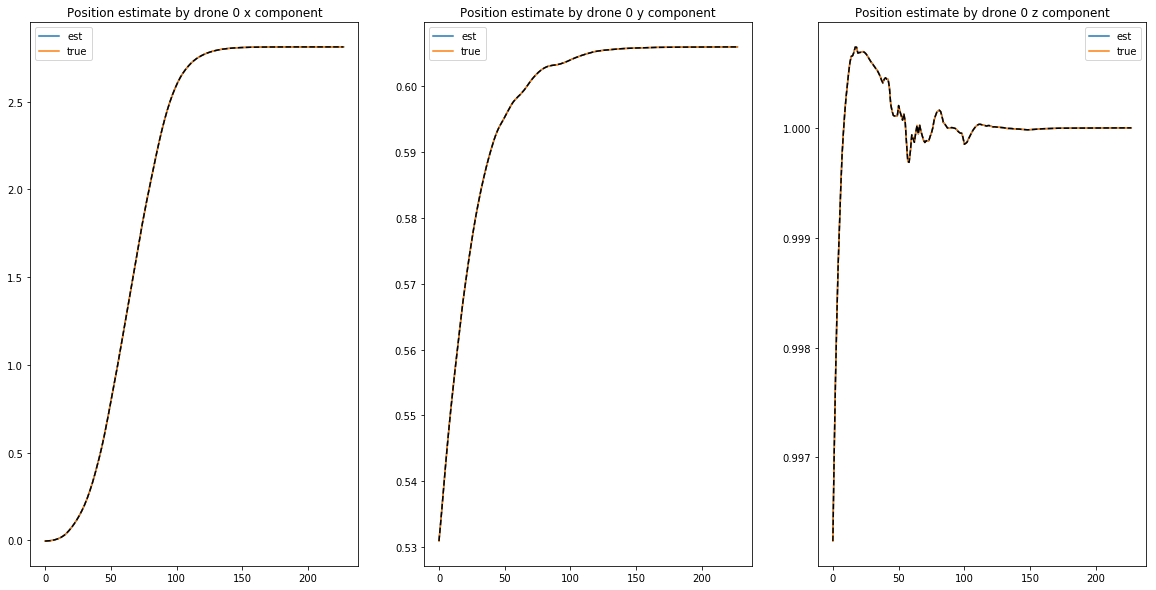

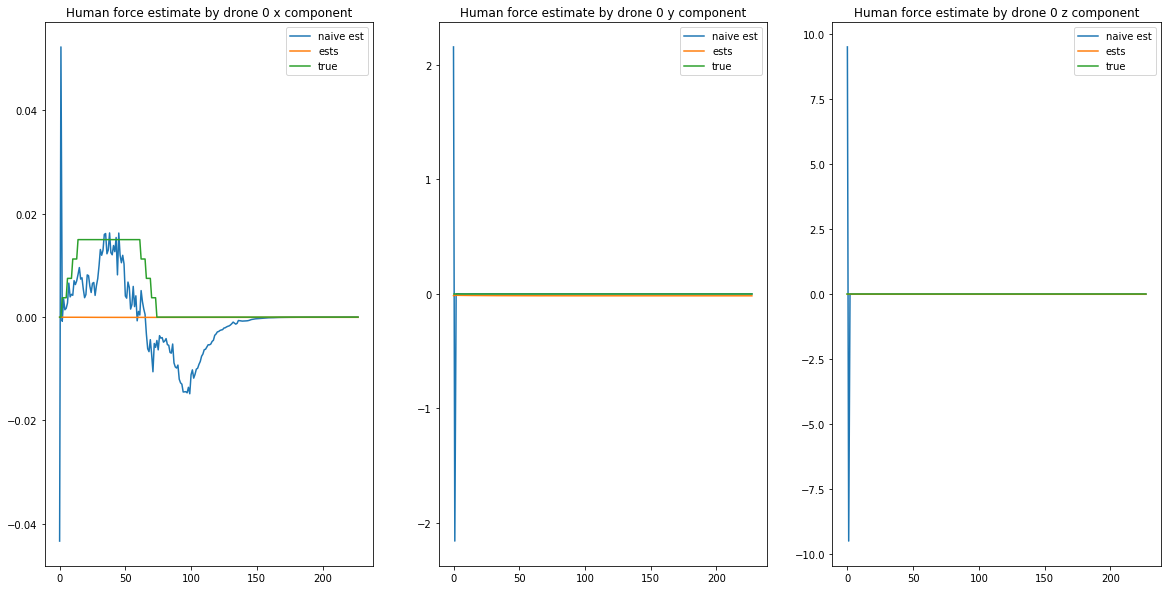

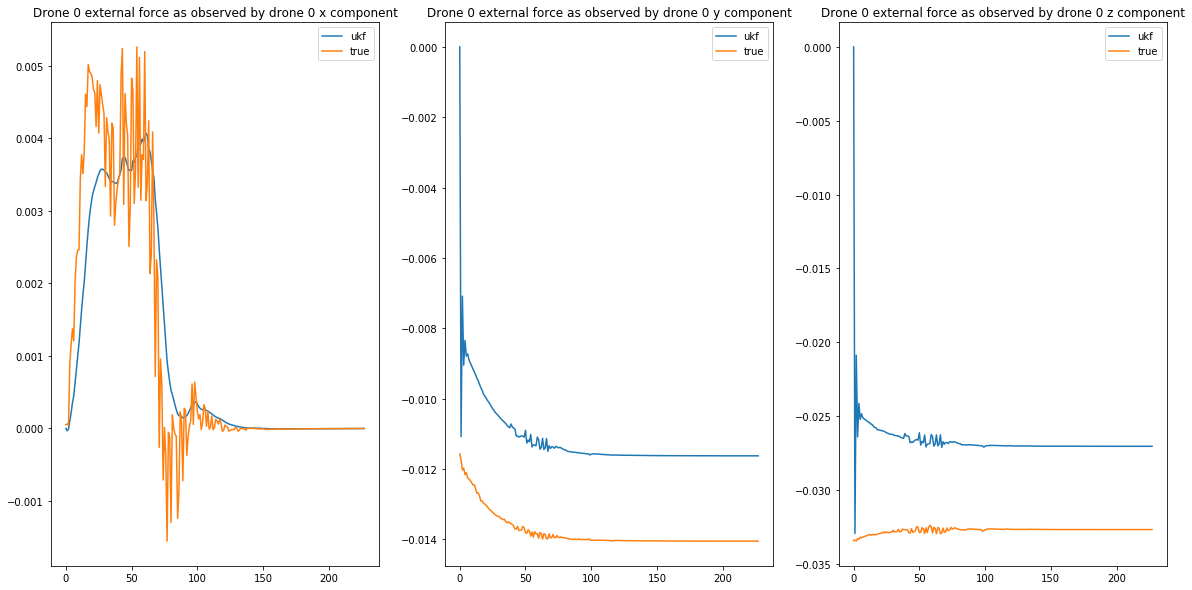

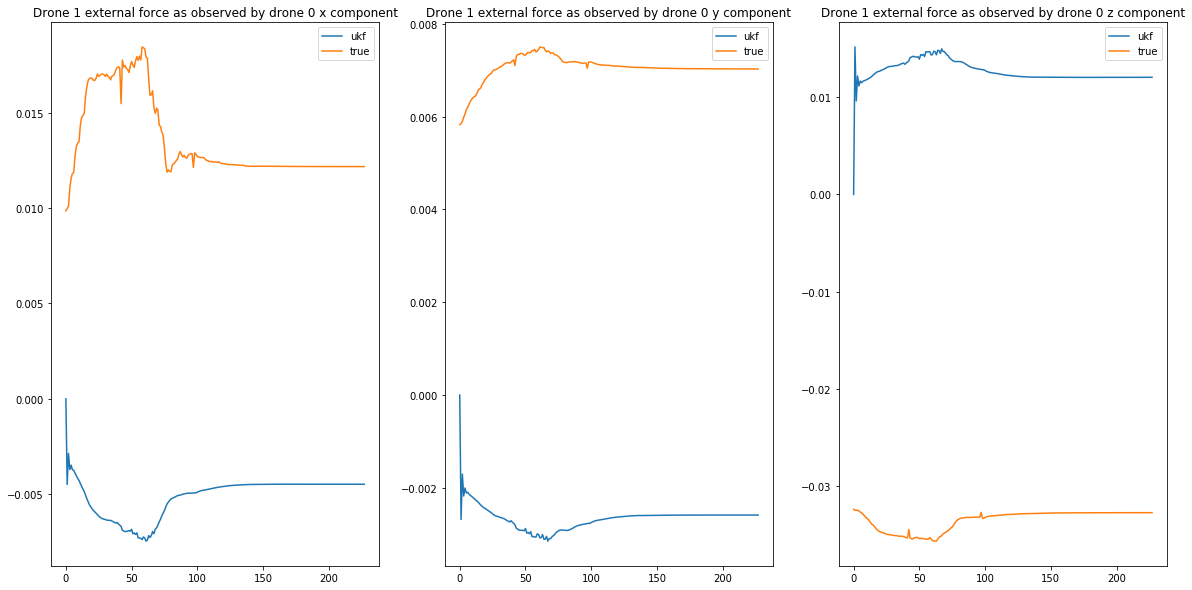

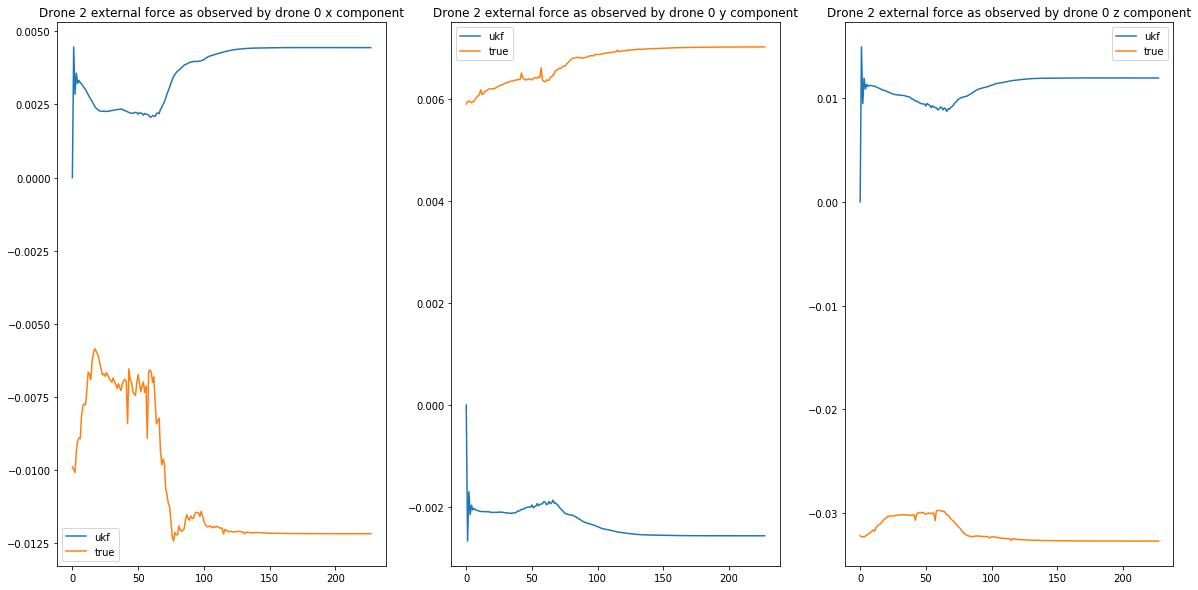

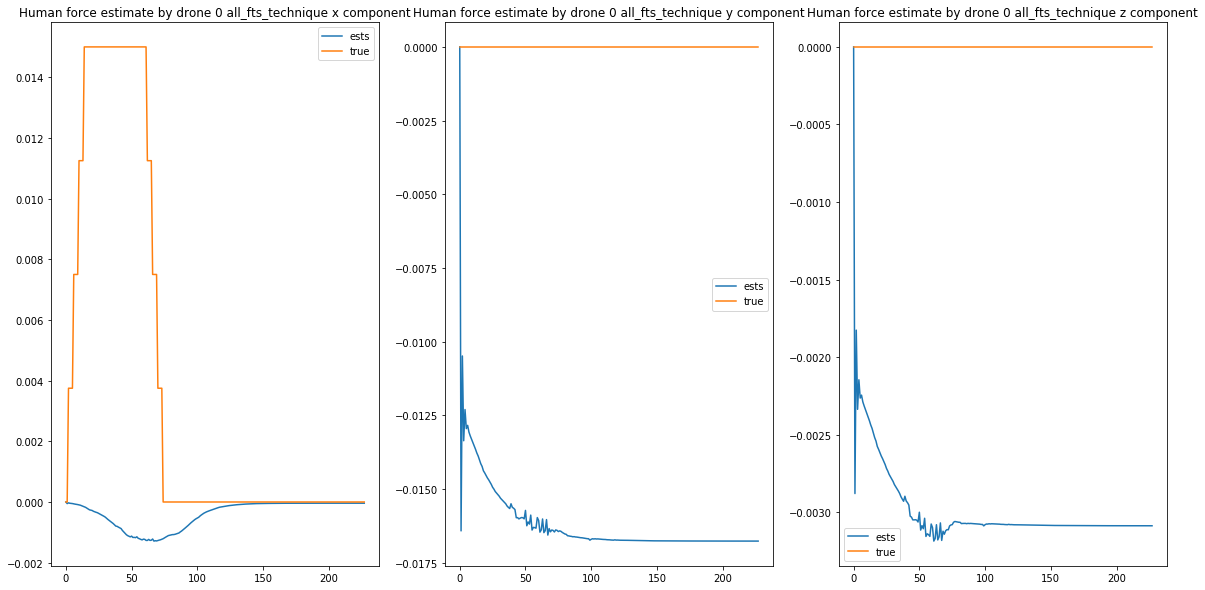

In [40]:
do_everything(0)

100%|██████████| 228/228 [00:02<00:00, 89.96it/s]


array([[ 0.014,  0.008, -0.003],
       [ 0.013,  0.008, -0.003],
       [ 0.014,  0.008, -0.003],
       [ 0.014,  0.008, -0.003],
       [ 0.014,  0.008, -0.003],
       [ 0.014,  0.008, -0.003],
       [ 0.014,  0.008, -0.003],
       [ 0.014,  0.008, -0.003],
       [ 0.015,  0.009, -0.003],
       [ 0.015,  0.009, -0.003],
       [ 0.015,  0.009, -0.003],
       [ 0.015,  0.009, -0.003],
       [ 0.016,  0.009, -0.003],
       [ 0.016,  0.009, -0.003],
       [ 0.016,  0.009, -0.003],
       [ 0.016,  0.009, -0.003],
       [ 0.016,  0.009, -0.003],
       [ 0.016,  0.009, -0.003],
       [ 0.017,  0.01 , -0.003],
       [ 0.017,  0.01 , -0.003],
       [ 0.017,  0.01 , -0.003],
       [ 0.017,  0.01 , -0.003],
       [ 0.017,  0.01 , -0.003],
       [ 0.017,  0.01 , -0.003],
       [ 0.017,  0.01 , -0.003],
       [ 0.017,  0.01 , -0.003],
       [ 0.018,  0.01 , -0.003],
       [ 0.018,  0.01 , -0.003],
       [ 0.018,  0.01 , -0.003],
       [ 0.018,  0.01 , -0.003],
       [ 0

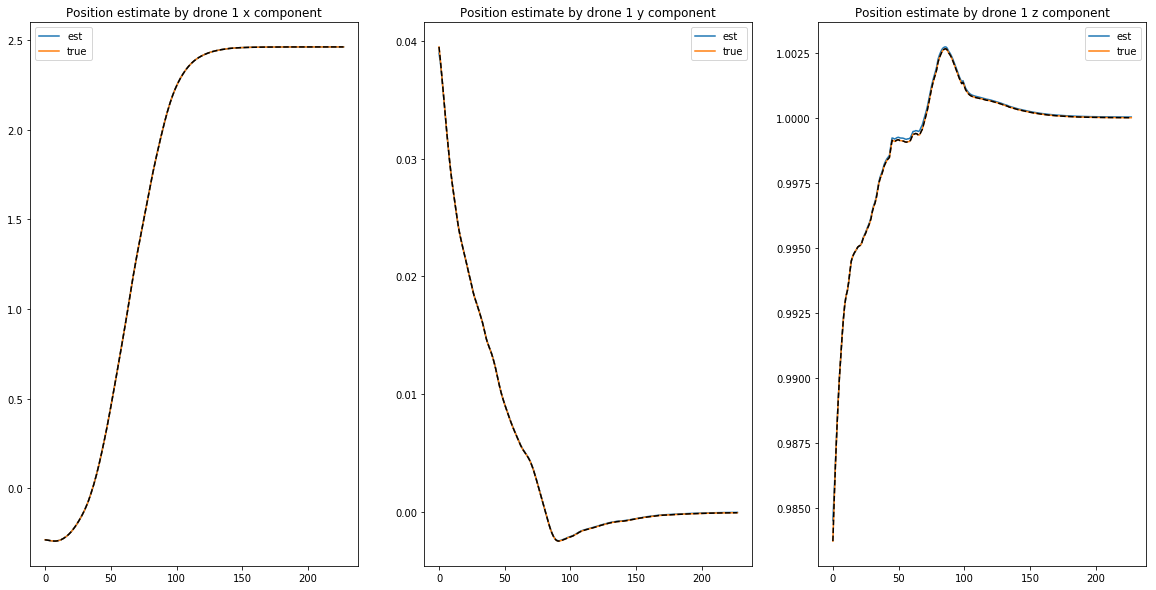

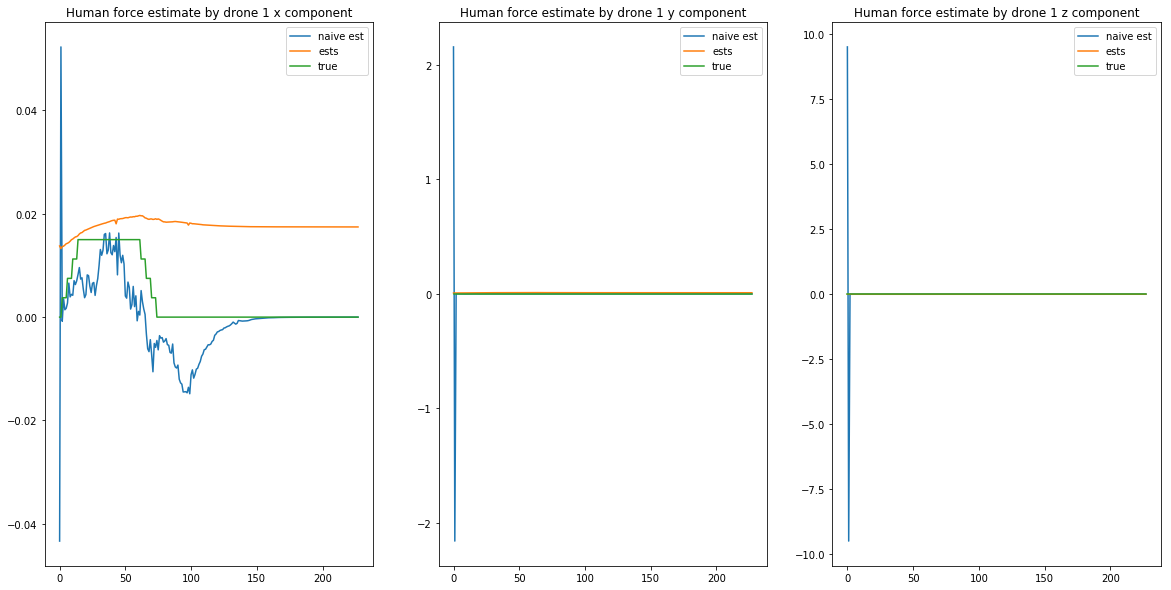

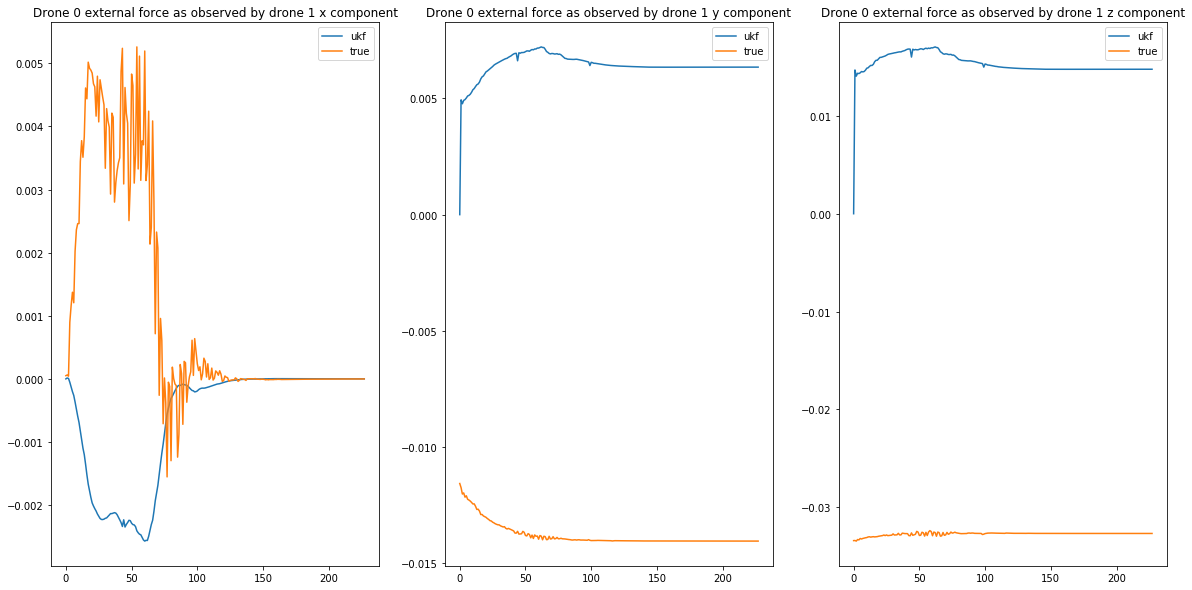

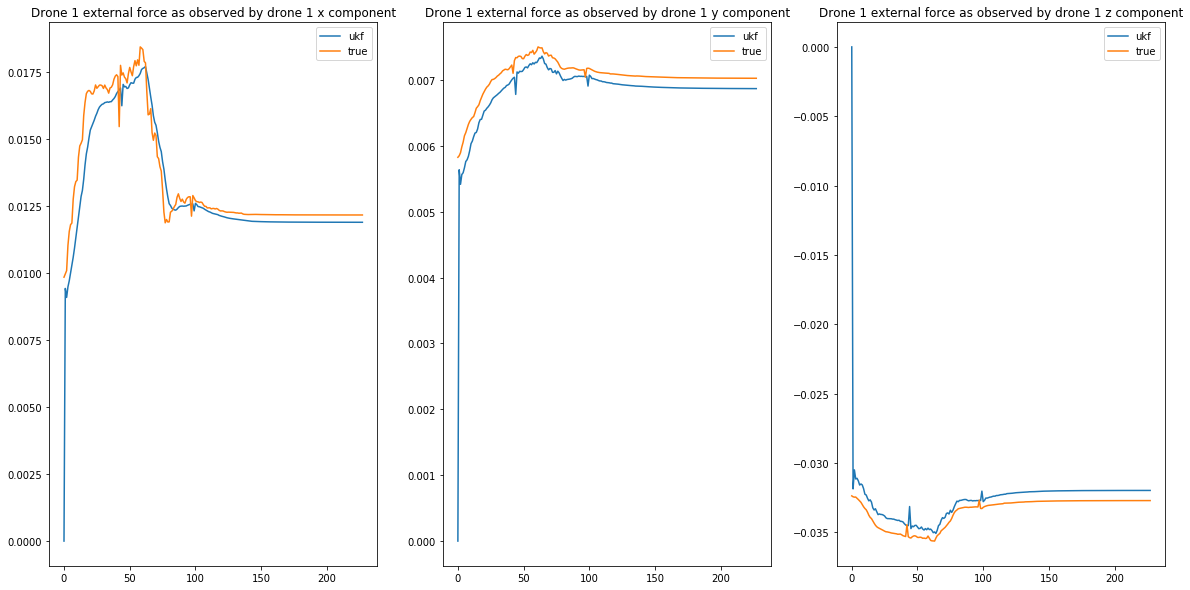

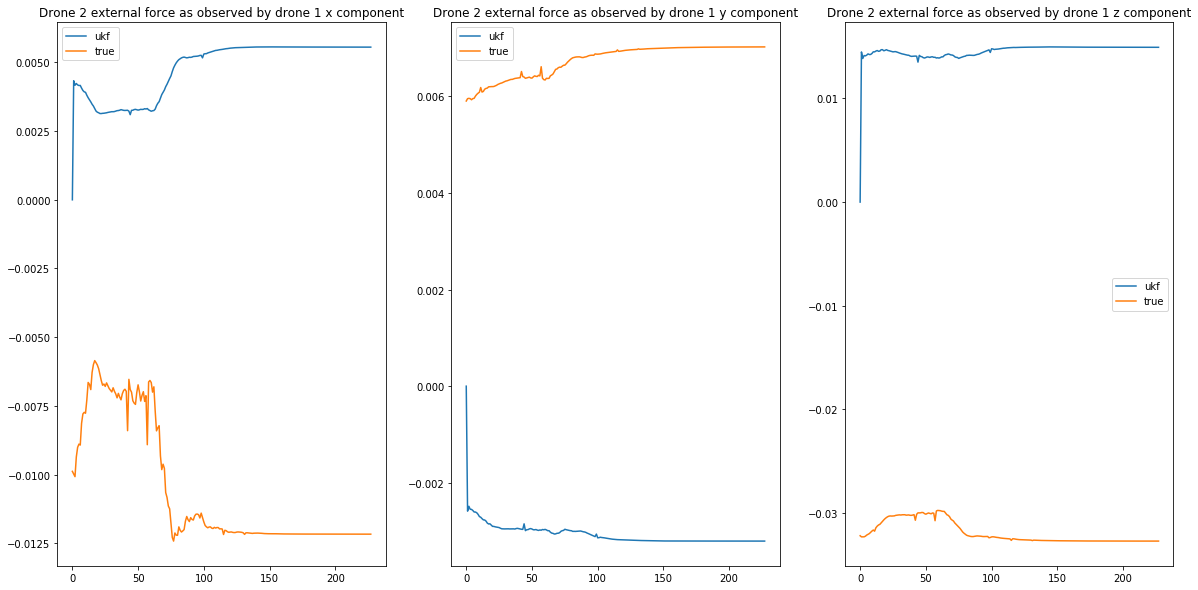

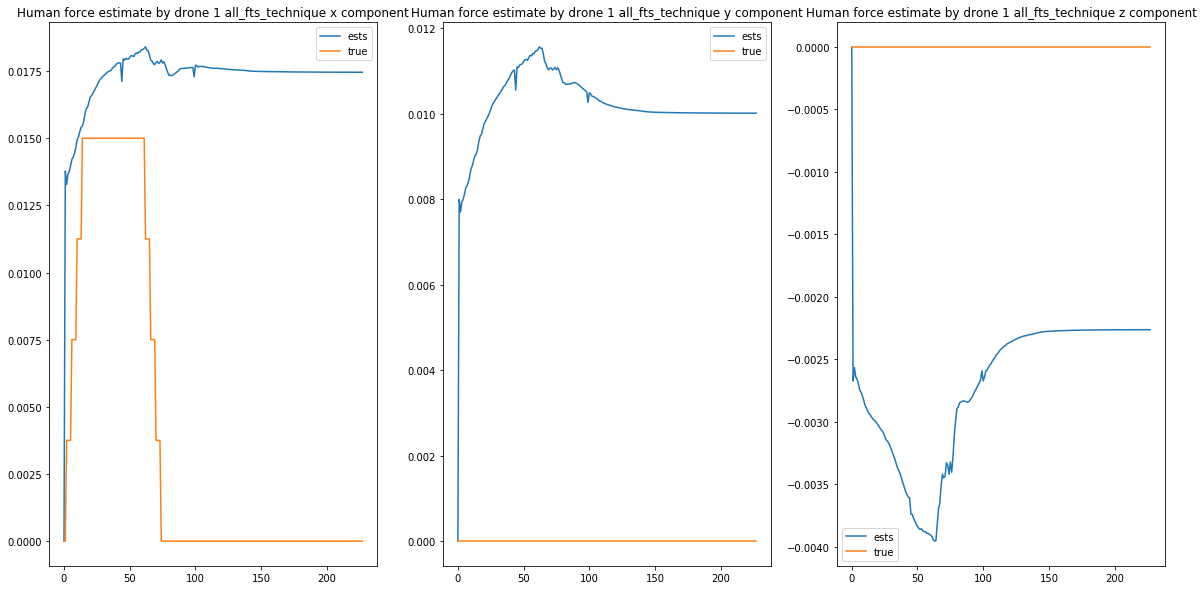

In [35]:
do_everything(1)

> <ipython-input-21-0a2db08cbcb6>(34)do_everything()
     33     import ipdb; ipdb.set_trace()
---> 34     all_ys = []
     35     all_FBox_est = []

ipdb> c
> <ipython-input-21-0a2db08cbcb6>(37)do_everything()
     36     import ipdb; ipdb.set_trace()
---> 37     for i in tqdm(range(i_init, full_states[0].shape[0])):
     38         y, u, x_other_drones, x_box = get_measurements(full_states, processed, i, curr_drone, other_drones)

ipdb> c


100%|██████████| 228/228 [00:02<00:00, 108.02it/s]


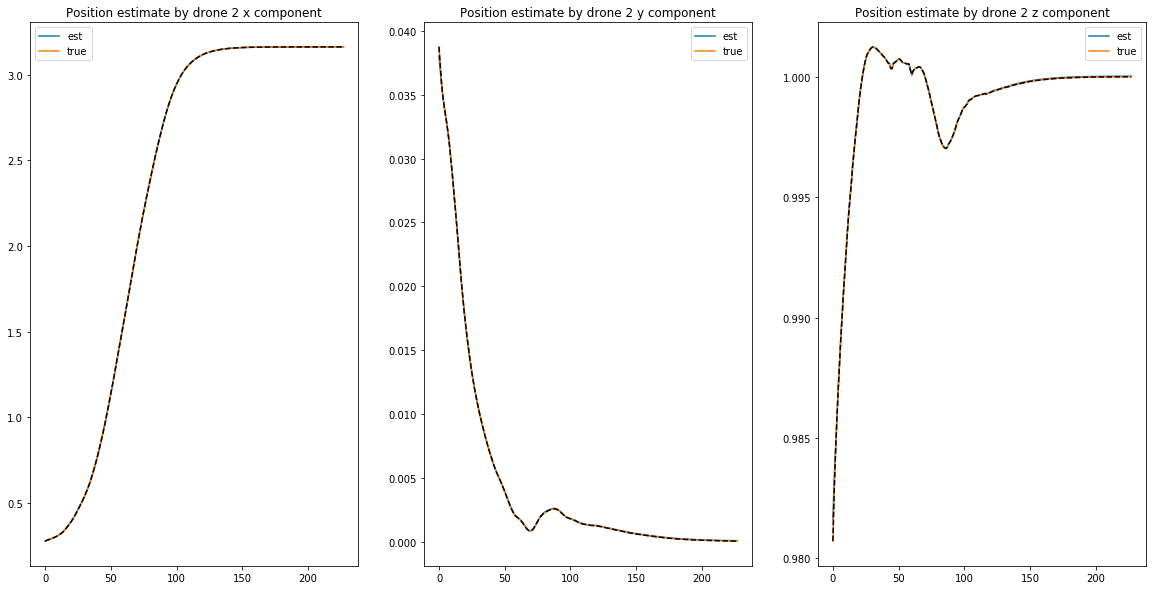

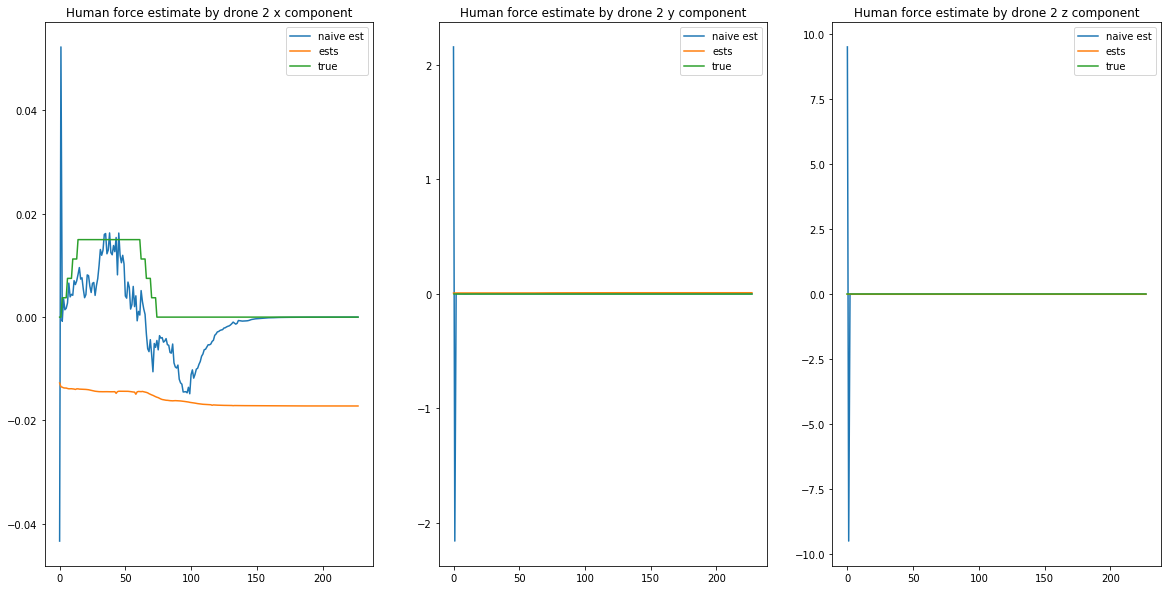

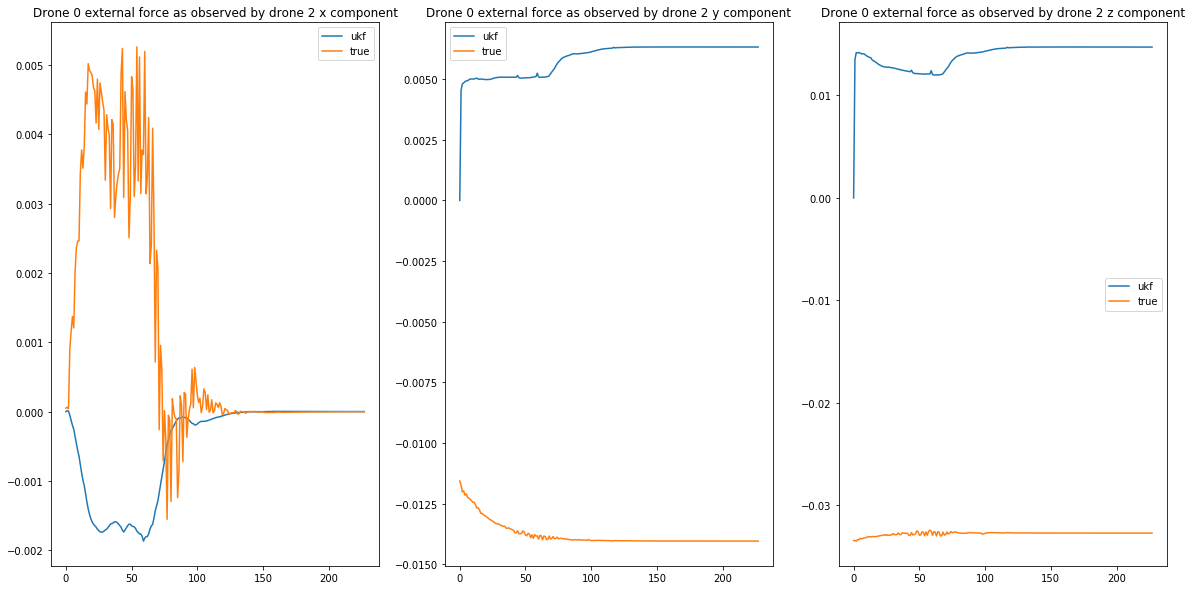

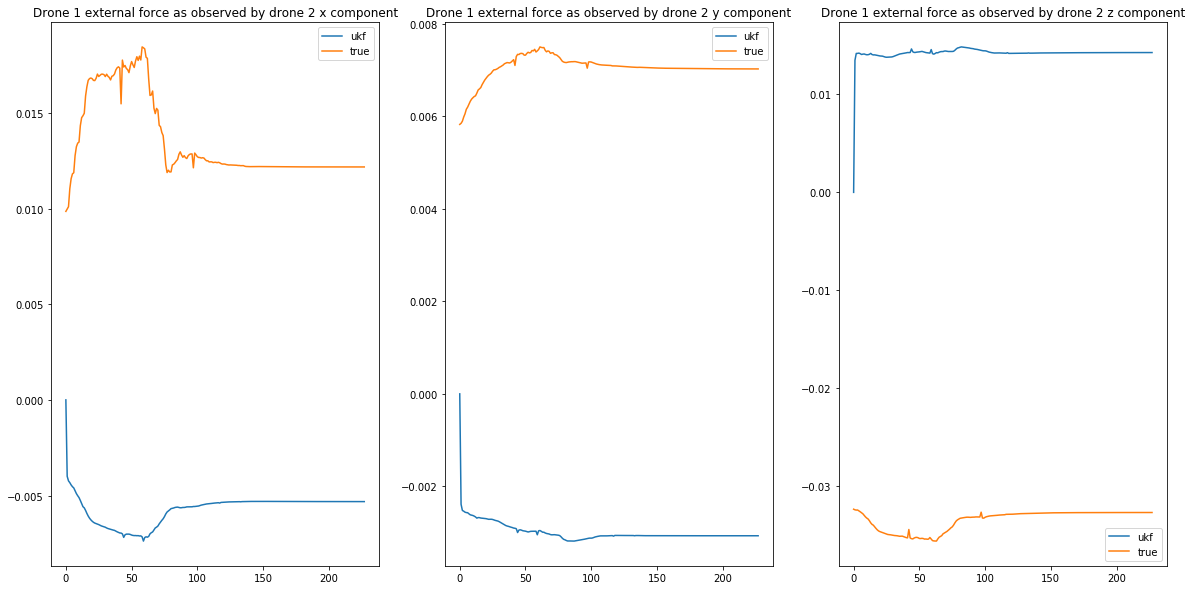

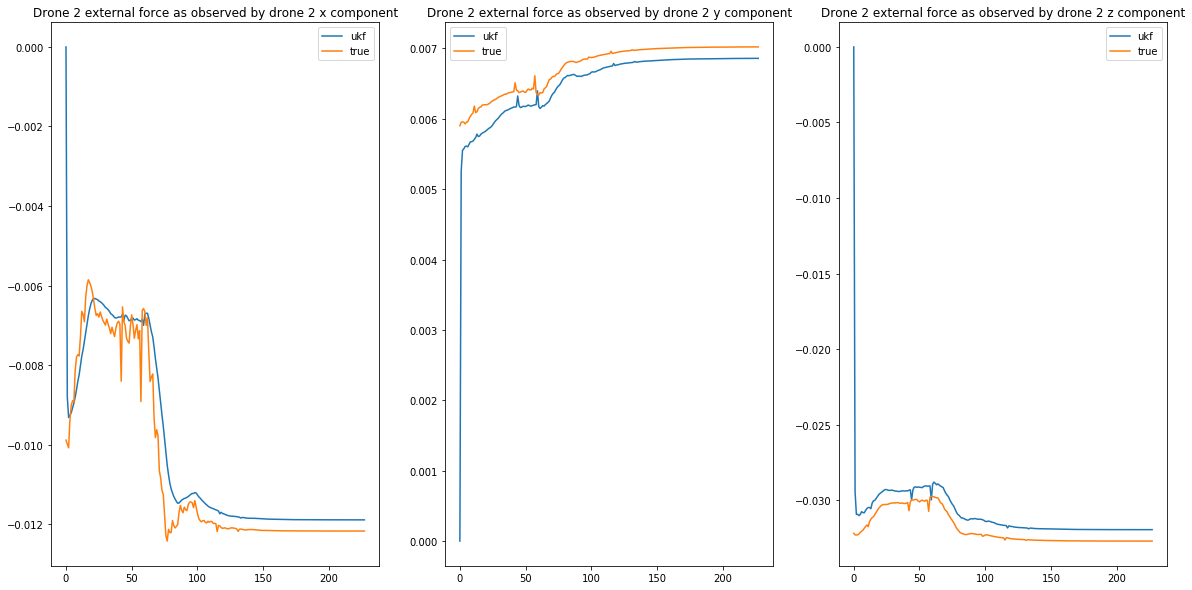

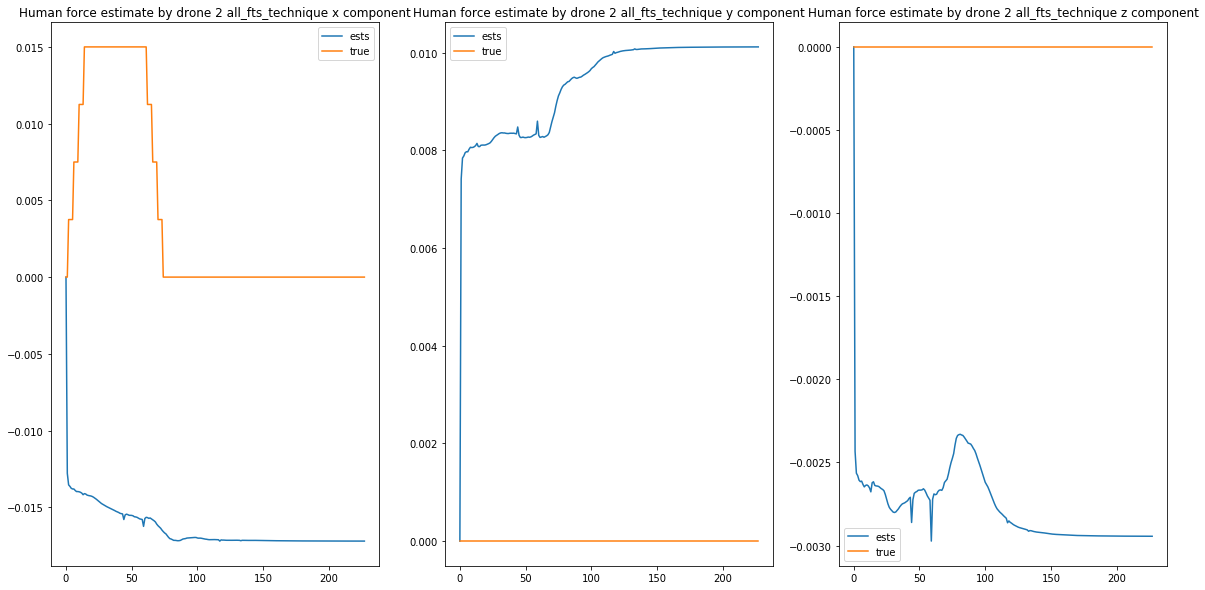

In [24]:
do_everything(2)

Why doesn't it work?
Theory: The unobserved states (F_box_x and F_box_y aren't influenced much by the observed states). F_ext_2, F_ext_3 do not influence the dynamics of this drone. Three separate estimators don't make sense because we don't observe U of each of the drones either. Options: 
- Create a new state with the right set of properties
- Estimate U of other drones using another heuristic estimator (like an NN?). Why could this work? If we only need a coarse estimate of U it is obtained by solving this MPC, and the goal state can be assumed to be symetrically away from the current drone?

100%|██████████| 228/228 [00:00<00:00, 234.01it/s]


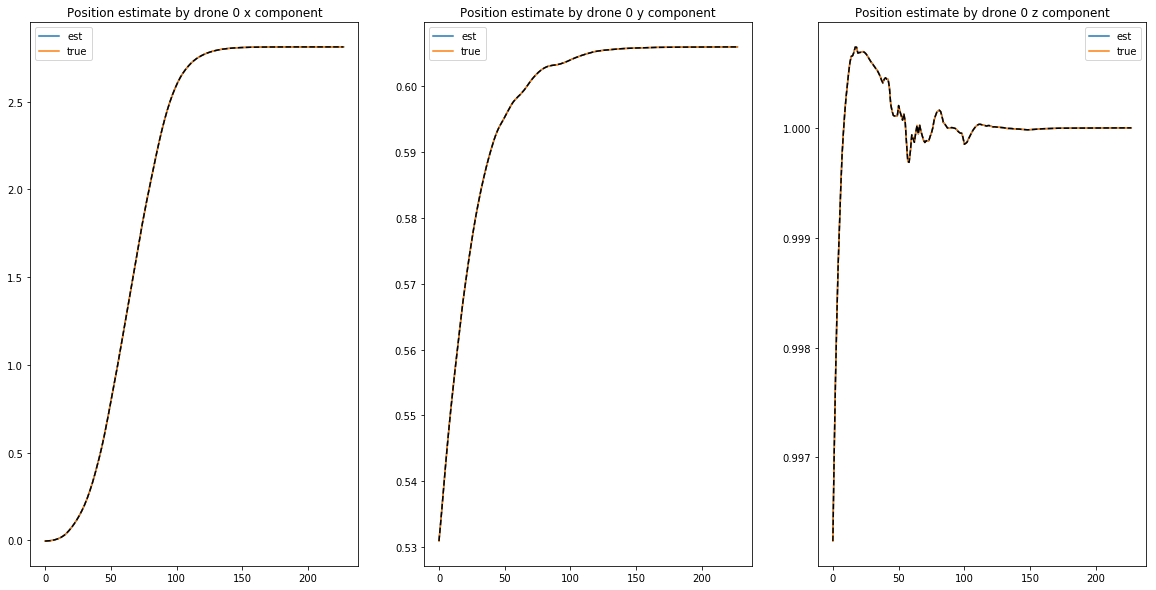

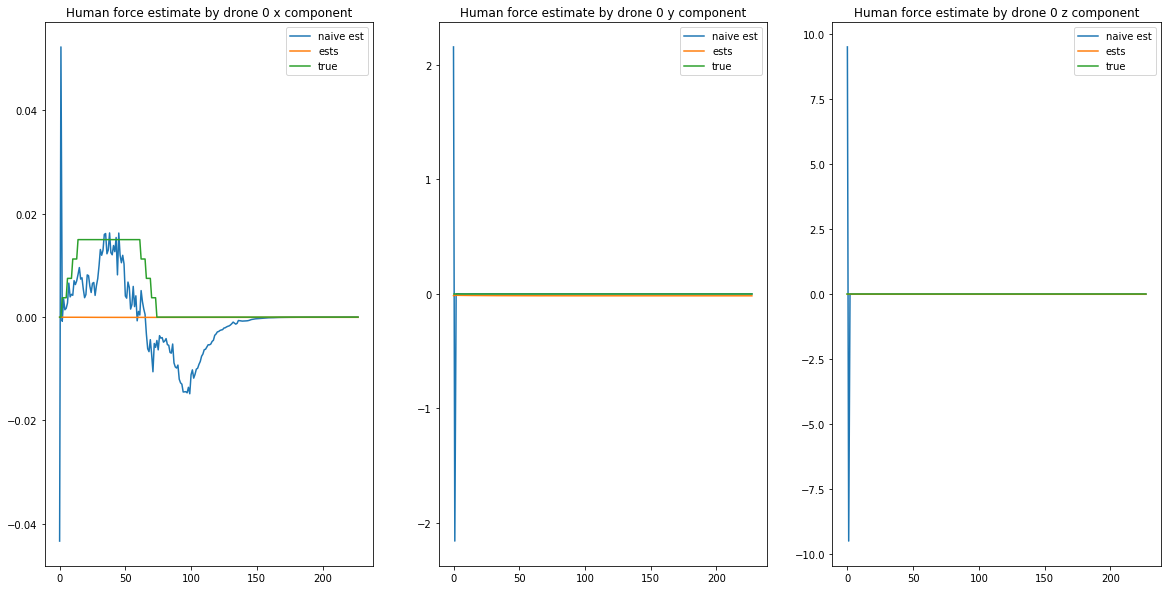

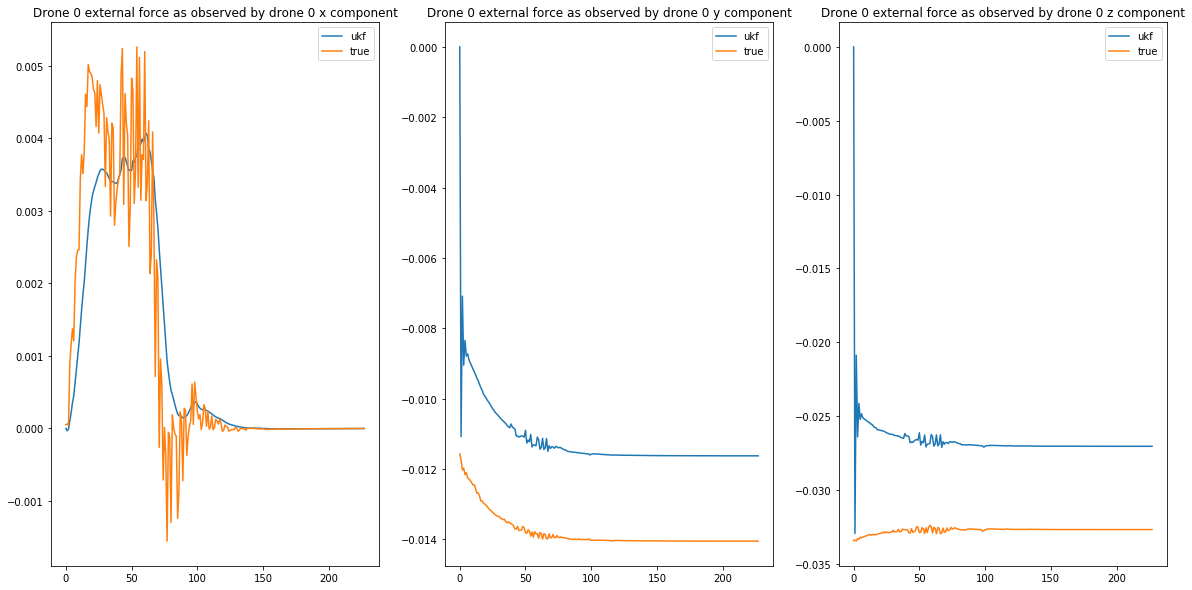

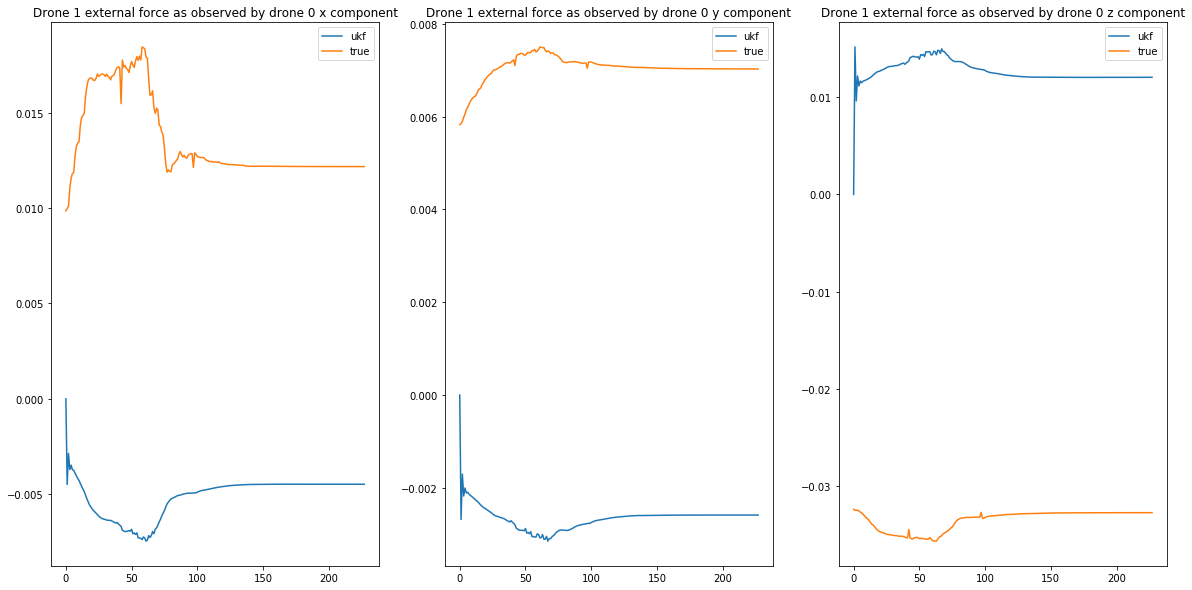

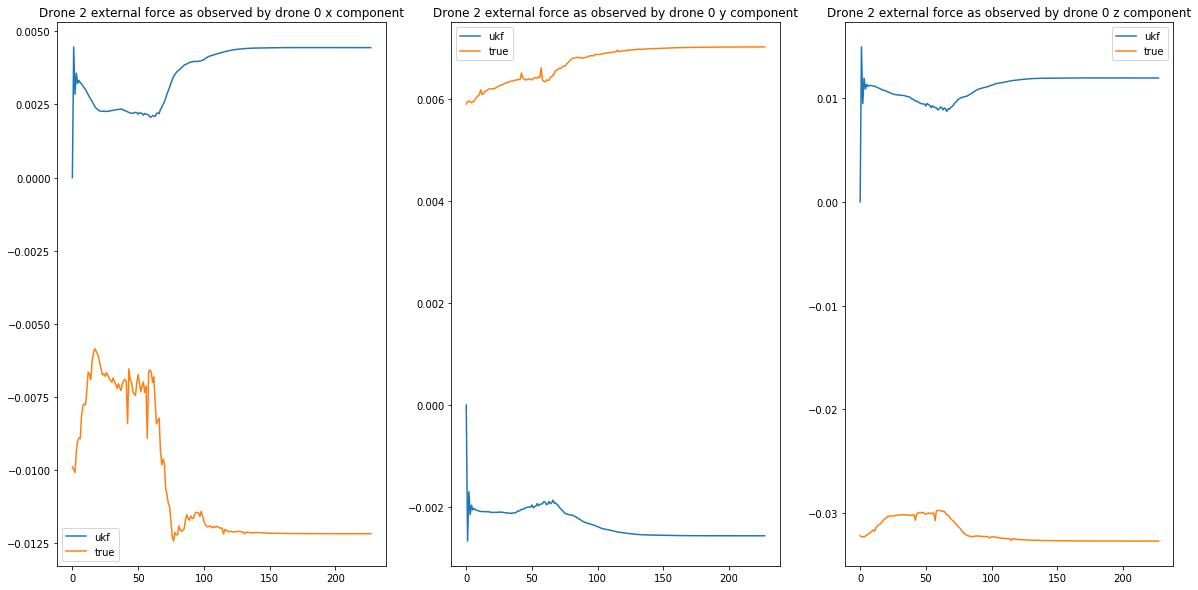

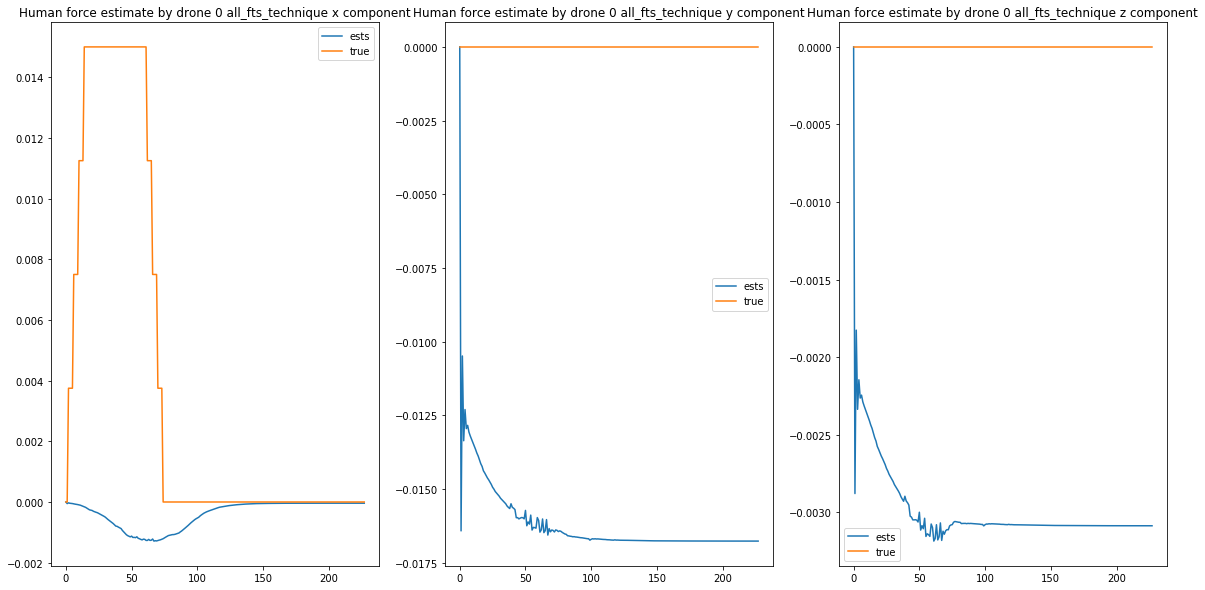

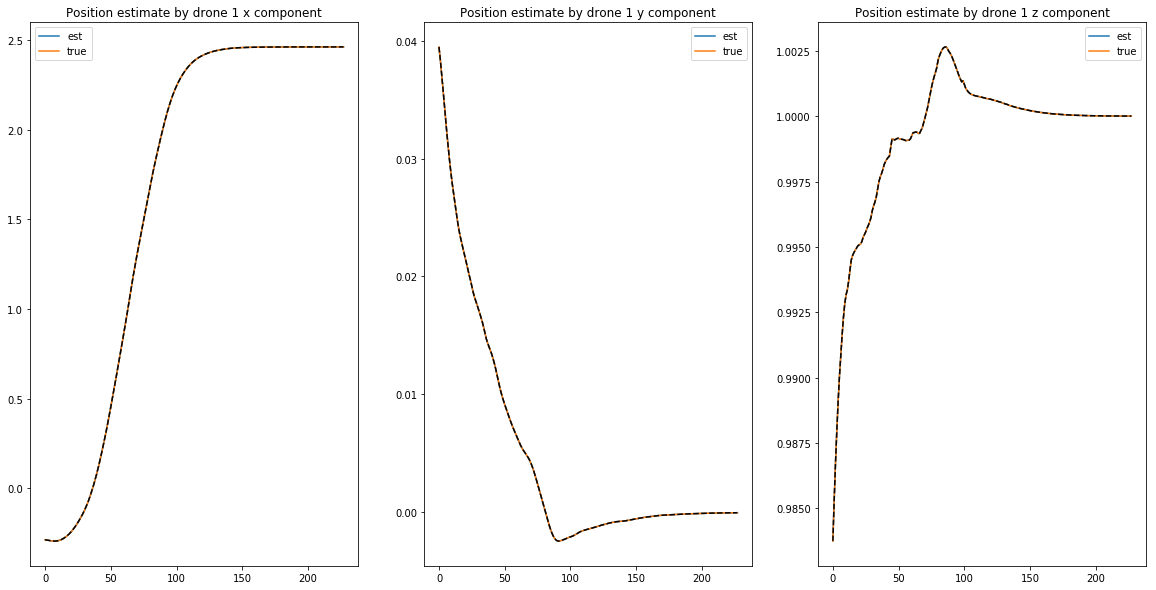

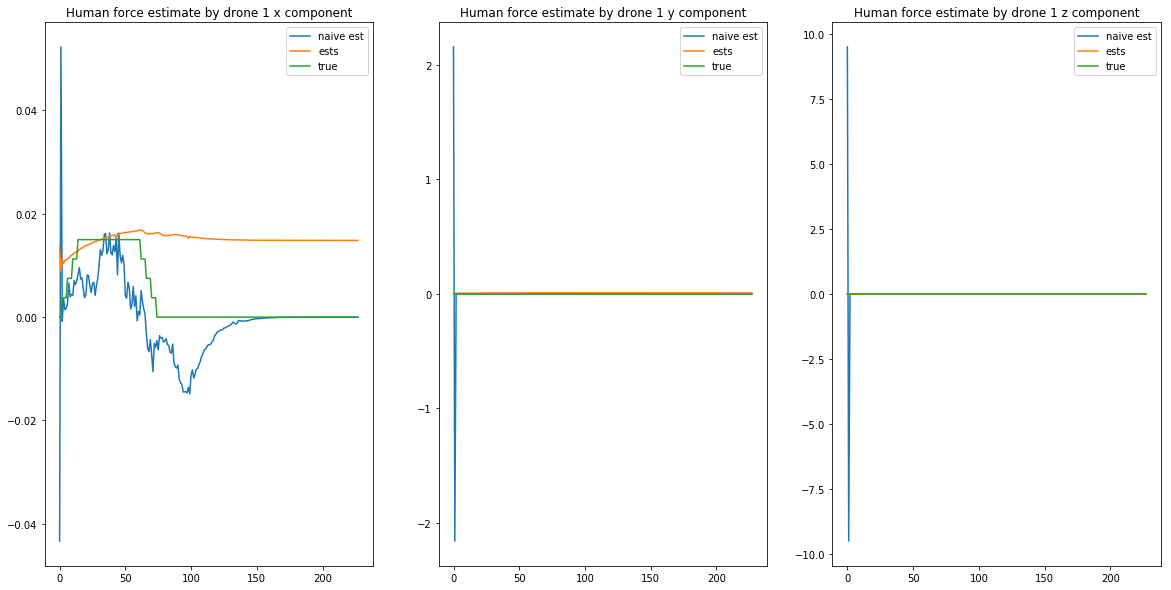

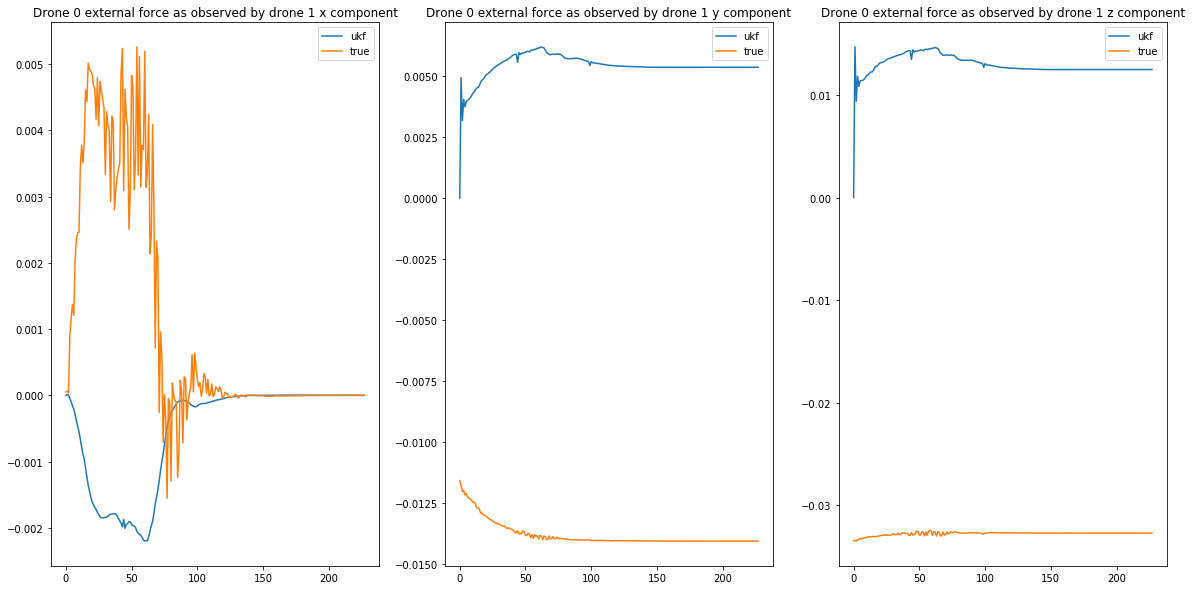

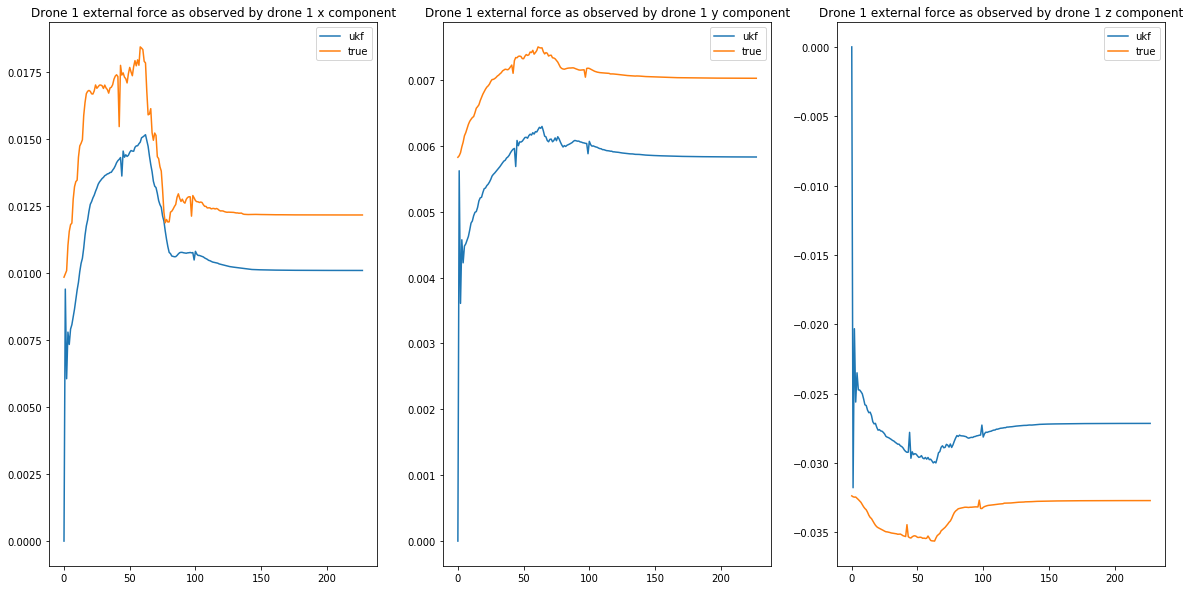

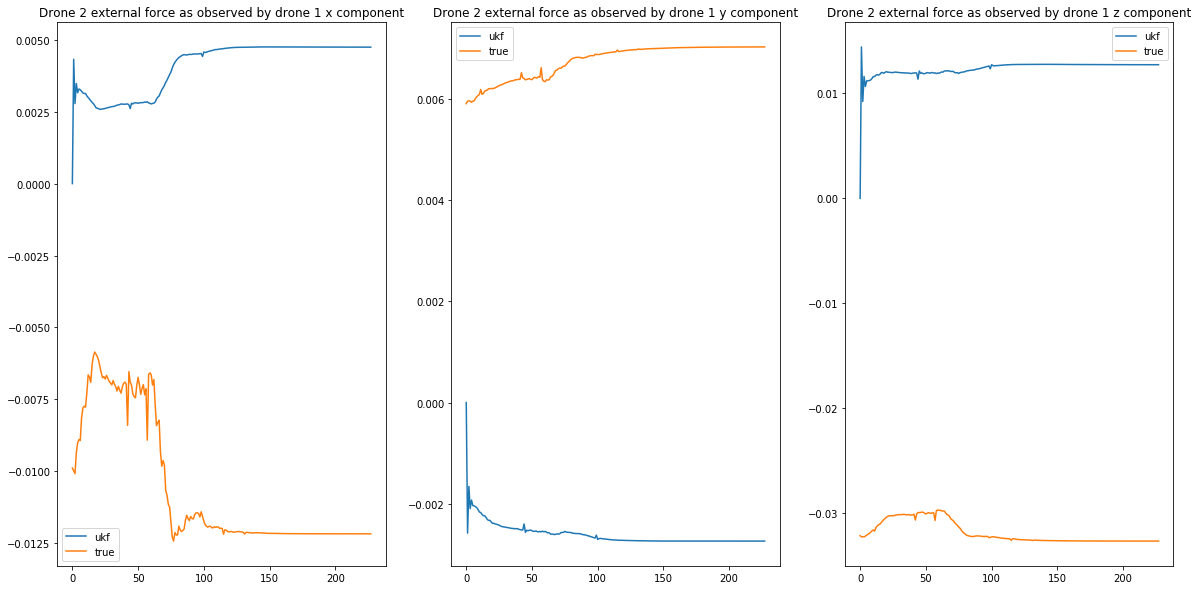

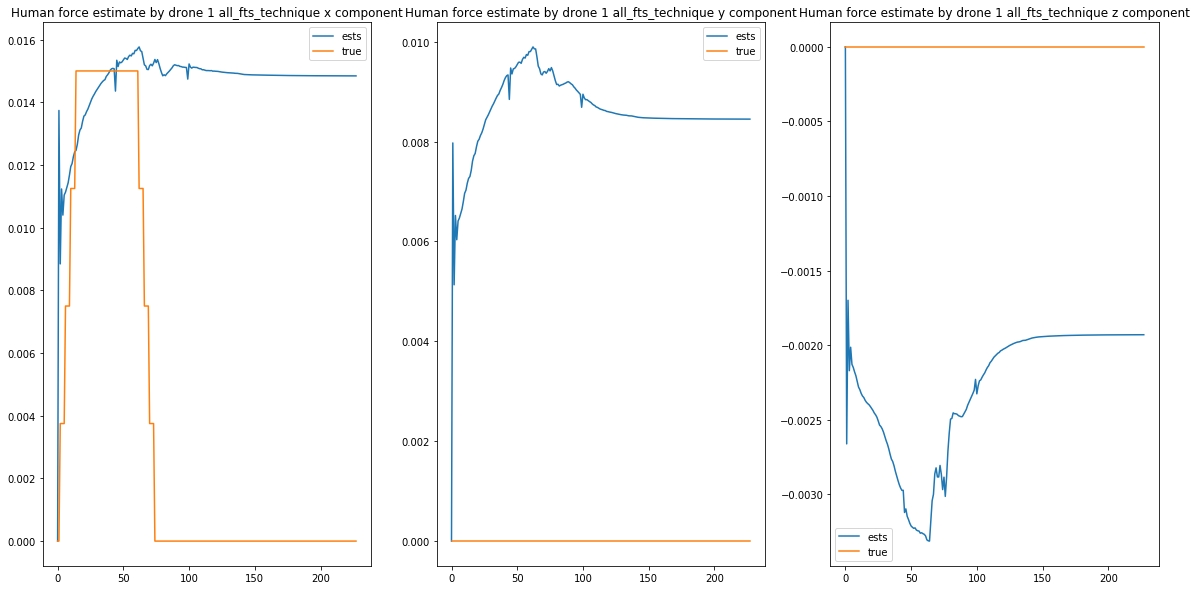

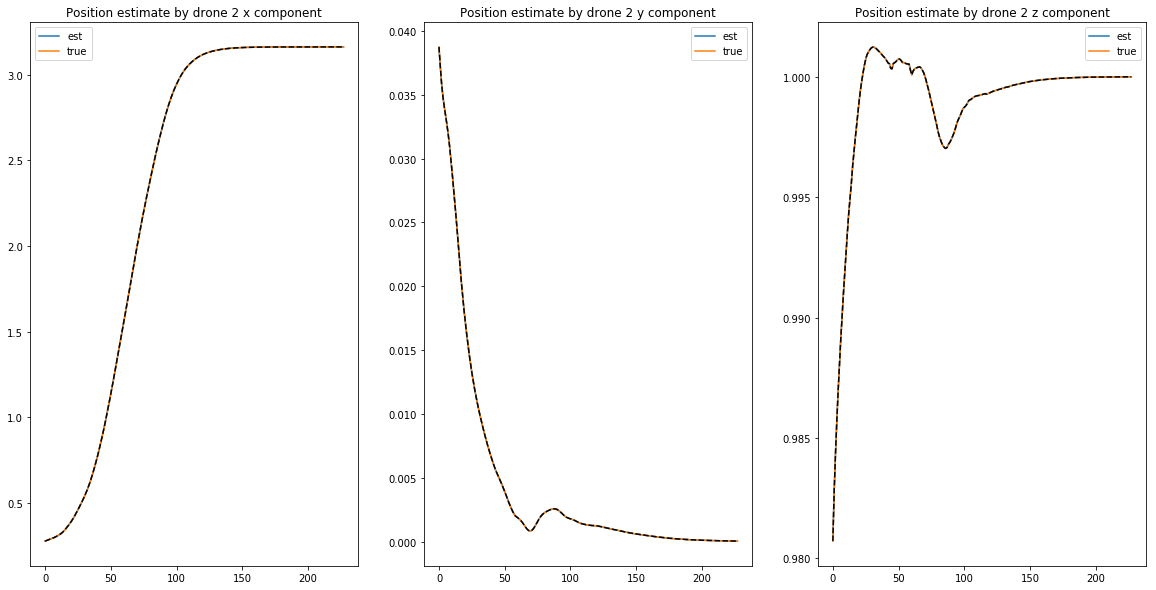

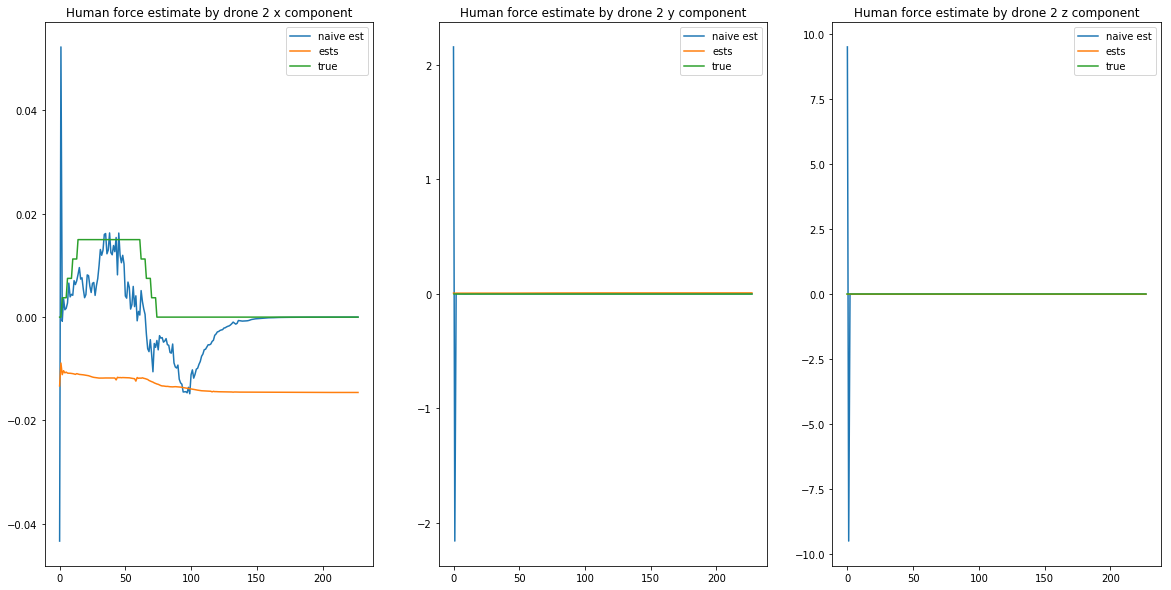

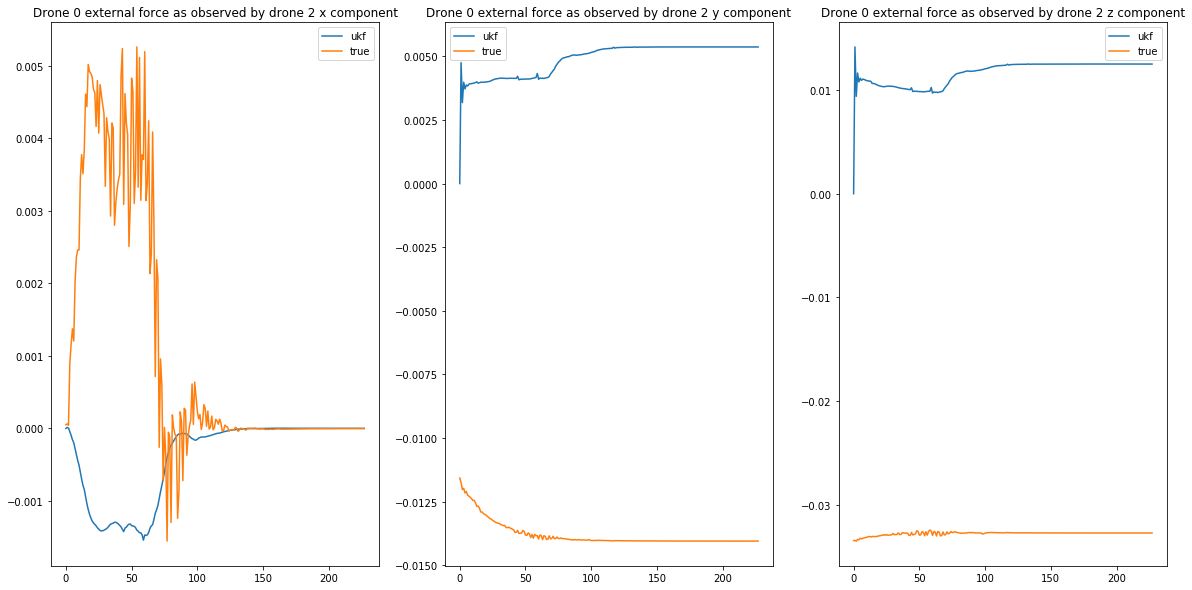

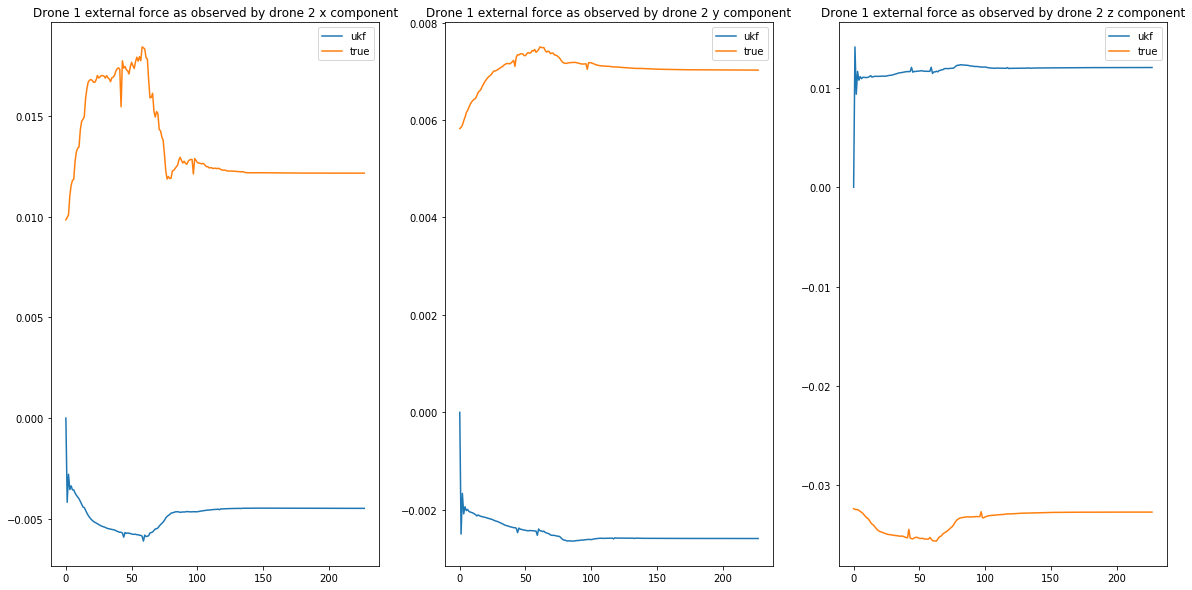

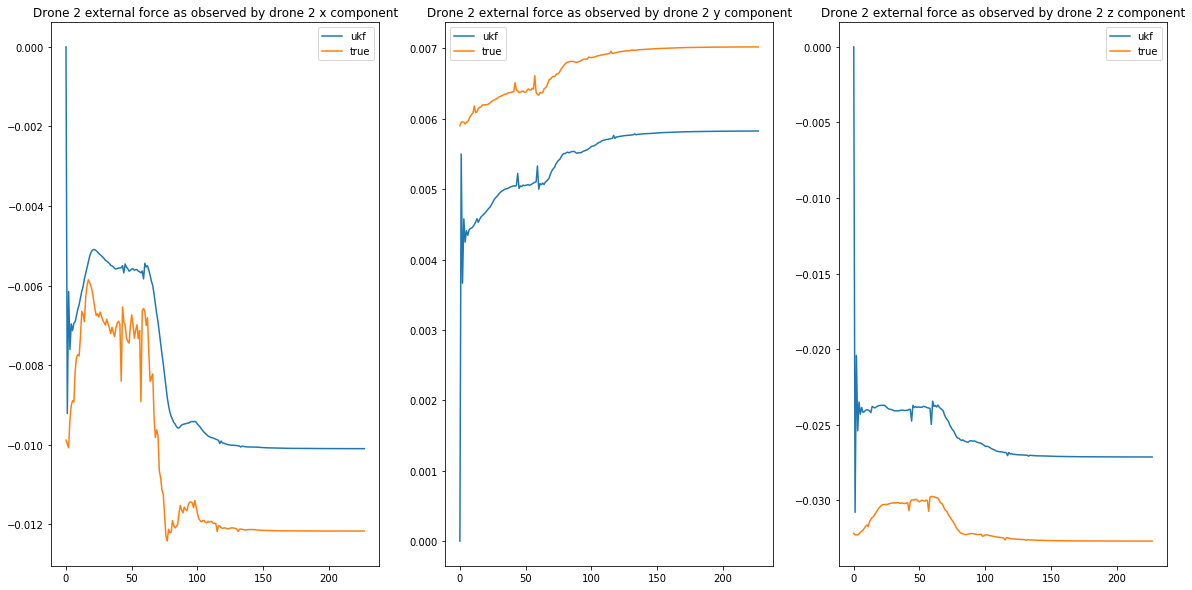

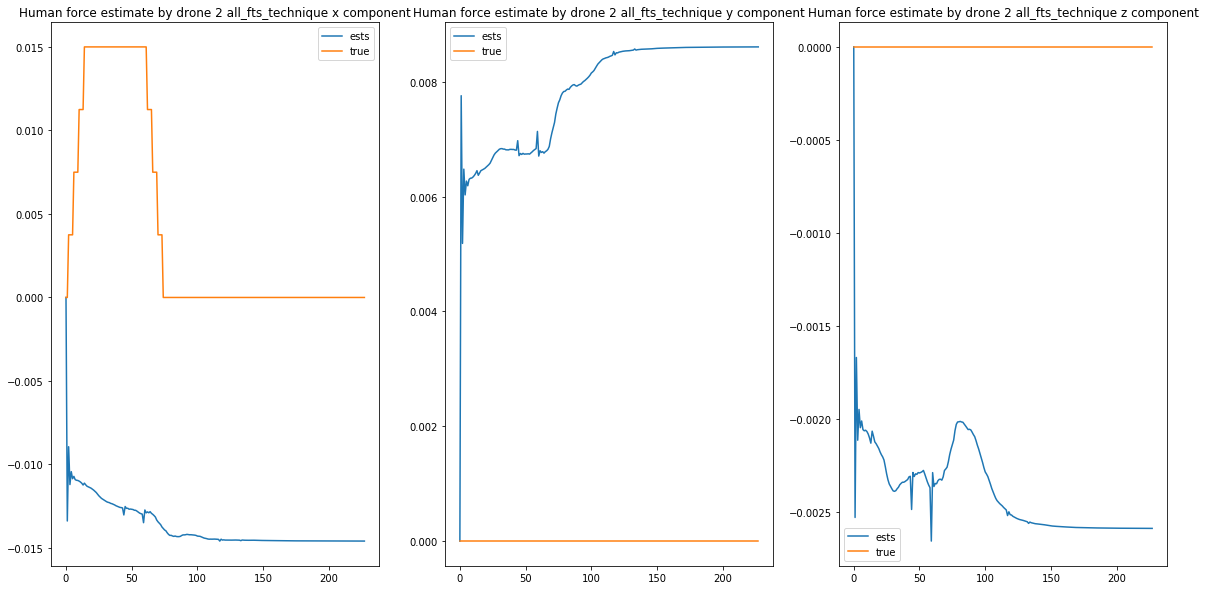

In [41]:
F_humans_all = [do_everything(i) for i in range(3)]

In [42]:
total_force = sum(F_humans_all)

(<matplotlib.axes._subplots.AxesSubplot at 0x104449d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x111df5d30>)

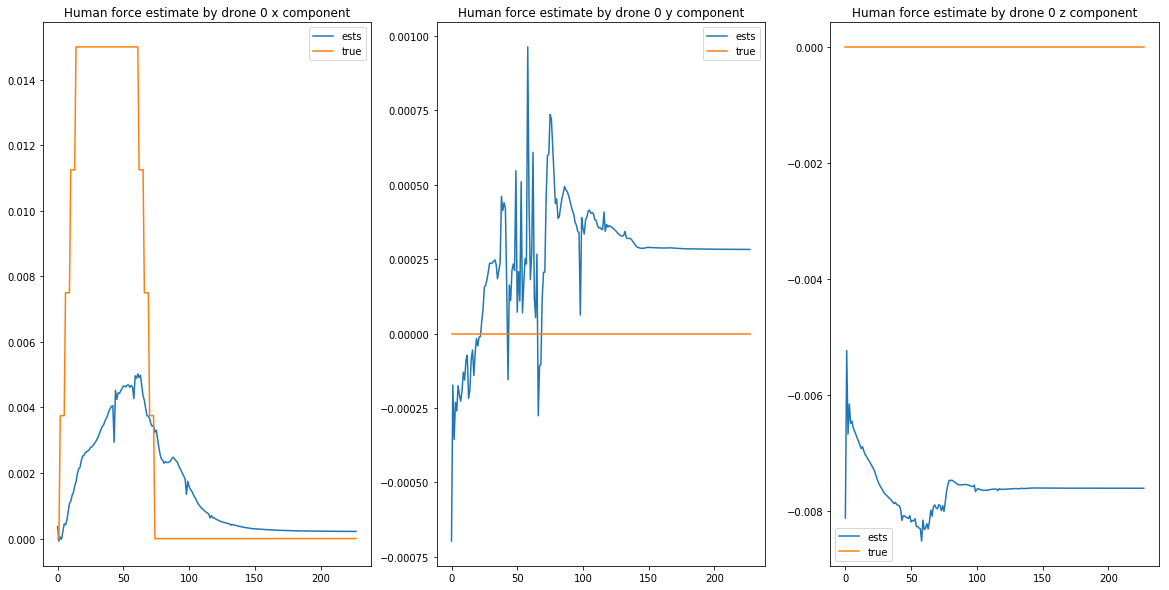

In [43]:
i_init = 45
plot.plot_vectors(total_force, processed[BOX][F_HUMAN][i_init:,1:], 
                      names=[ "ests", "true"], 
                      title="Human force estimate by drone {}".format(0))

## New State Attempt